In [151]:
# Loading neccesary packages:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

#
from scipy import stats
from scipy.stats import skew, boxcox_normmax, norm
from scipy.special import boxcox1p

#
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

#
import warnings
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

#
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [152]:
# Import dataset
os.chdir(r'C:\Users\Jaehyun Ahn\Desktop\dacon\ev_prediction')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

# Change the column to English
train = train.rename(columns={'제조사':'Brand',
                     '모델':'Model',
                     '차량상태':'Car Condition',
                     '배터리용량':'Battery Capacity',
                     '구동방식':'Driving System',
                     '주행거리(km)':'Driving Distance',
                     '보증기간(년)':'Warranty',
                     '사고이력':'Accident History',
                     '연식(년)':'Old',
                     '가격(백만원)':'Price'})


test = test.rename(columns={'제조사':'Brand',
                     '모델':'Model',
                     '차량상태':'Car Condition',
                     '배터리용량':'Battery Capacity',
                     '구동방식':'Driving System',
                     '주행거리(km)':'Driving Distance',
                     '보증기간(년)':'Warranty',
                     '사고이력':'Accident History',
                     '연식(년)':'Old',
                     })

In [153]:
train.head()

,ID,Brand,Model,Car Condition,Battery Capacity,Driving System,Driving Distance,Warranty,Accident History,Old,Price
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02


In [154]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                7497 non-null   object 
 1   Brand             7497 non-null   object 
 2   Model             7497 non-null   object 
 3   Car Condition     7497 non-null   object 
 4   Battery Capacity  4786 non-null   float64
 5   Driving System    7497 non-null   object 
 6   Driving Distance  7497 non-null   int64  
 7   Warranty          7497 non-null   int64  
 8   Accident History  7497 non-null   object 
 9   Old               7497 non-null   int64  
 10  Price             7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [155]:
train.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,7497,7497,TRAIN_0000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Brand,7497,7,H사,1237,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Model,7497,21,ID4,605,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Car Condition,7497,3,Brand New,3380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Battery Capacity,4786.0,NaN,NaN,NaN,69.397187,15.283635,46.0,56.359,68.125,78.227,99.8
Driving System,7497,3,AWD,5167,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Driving Distance,7497.0,NaN,NaN,NaN,44287.979458,55204.064386,3.0,5465.0,17331.0,61252.0,199827.0
Warranty,7497.0,NaN,NaN,NaN,4.960918,3.155342,0.0,2.0,5.0,8.0,10.0
Accident History,7497,2,No,7154,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Old,7497.0,NaN,NaN,NaN,0.222489,0.569232,0.0,0.0,0.0,0.0,2.0


,Battery Capacity
Missing Values,2711.000000
Percent,36.161131


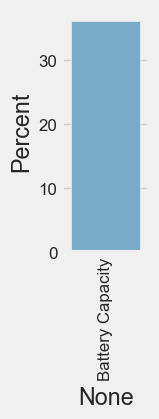

In [156]:
def missing_percentage(df):
    
    """A function for returning missing ratios."""
    
    total = df.isnull().sum().sort_values(
        ascending=False)[df.isnull().sum().sort_values(ascending=False) != 0]
    percent = (df.isnull().sum().sort_values(ascending=False) / len(df) *
               100)[(df.isnull().sum().sort_values(ascending=False) / len(df) *
                     100) != 0]
    return pd.concat([total, percent], axis=1, keys=['Missing Values', 'Percent'])

# Checking 'NaN' values.
missing = missing_percentage(train)

fig, ax = plt.subplots(figsize=(1, 3))
sns.barplot(x=missing.index, y='Percent', data=missing, palette='Blues_r')
plt.xticks(rotation=90)

display(missing.T.style.background_gradient(cmap='summer', axis=1))

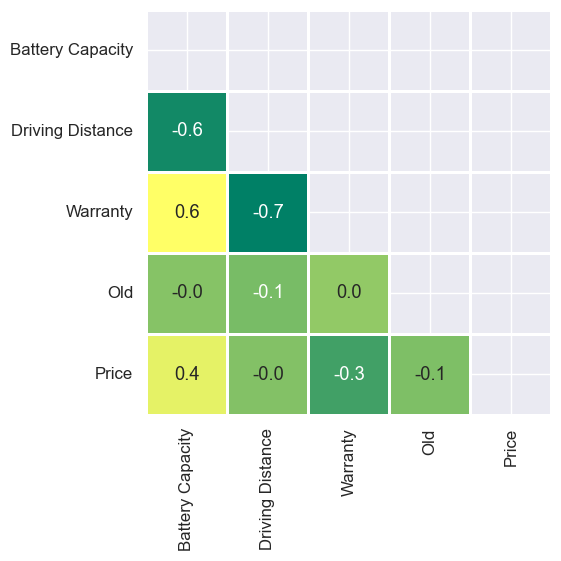

In [157]:
# Set the font scale for the heatmap
sns.set(font_scale=1.1)

# Calculate the correlation matrix for numerical features only
correlation_train = train.select_dtypes(include=['number']).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_train, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(5, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_train,
            annot=True,
            fmt='.1f',
            cmap='summer',
            square=True,
            mask=mask,
            linewidths=1,
            cbar=False)

# Show the plot
plt.show()

### Dealing with missing values

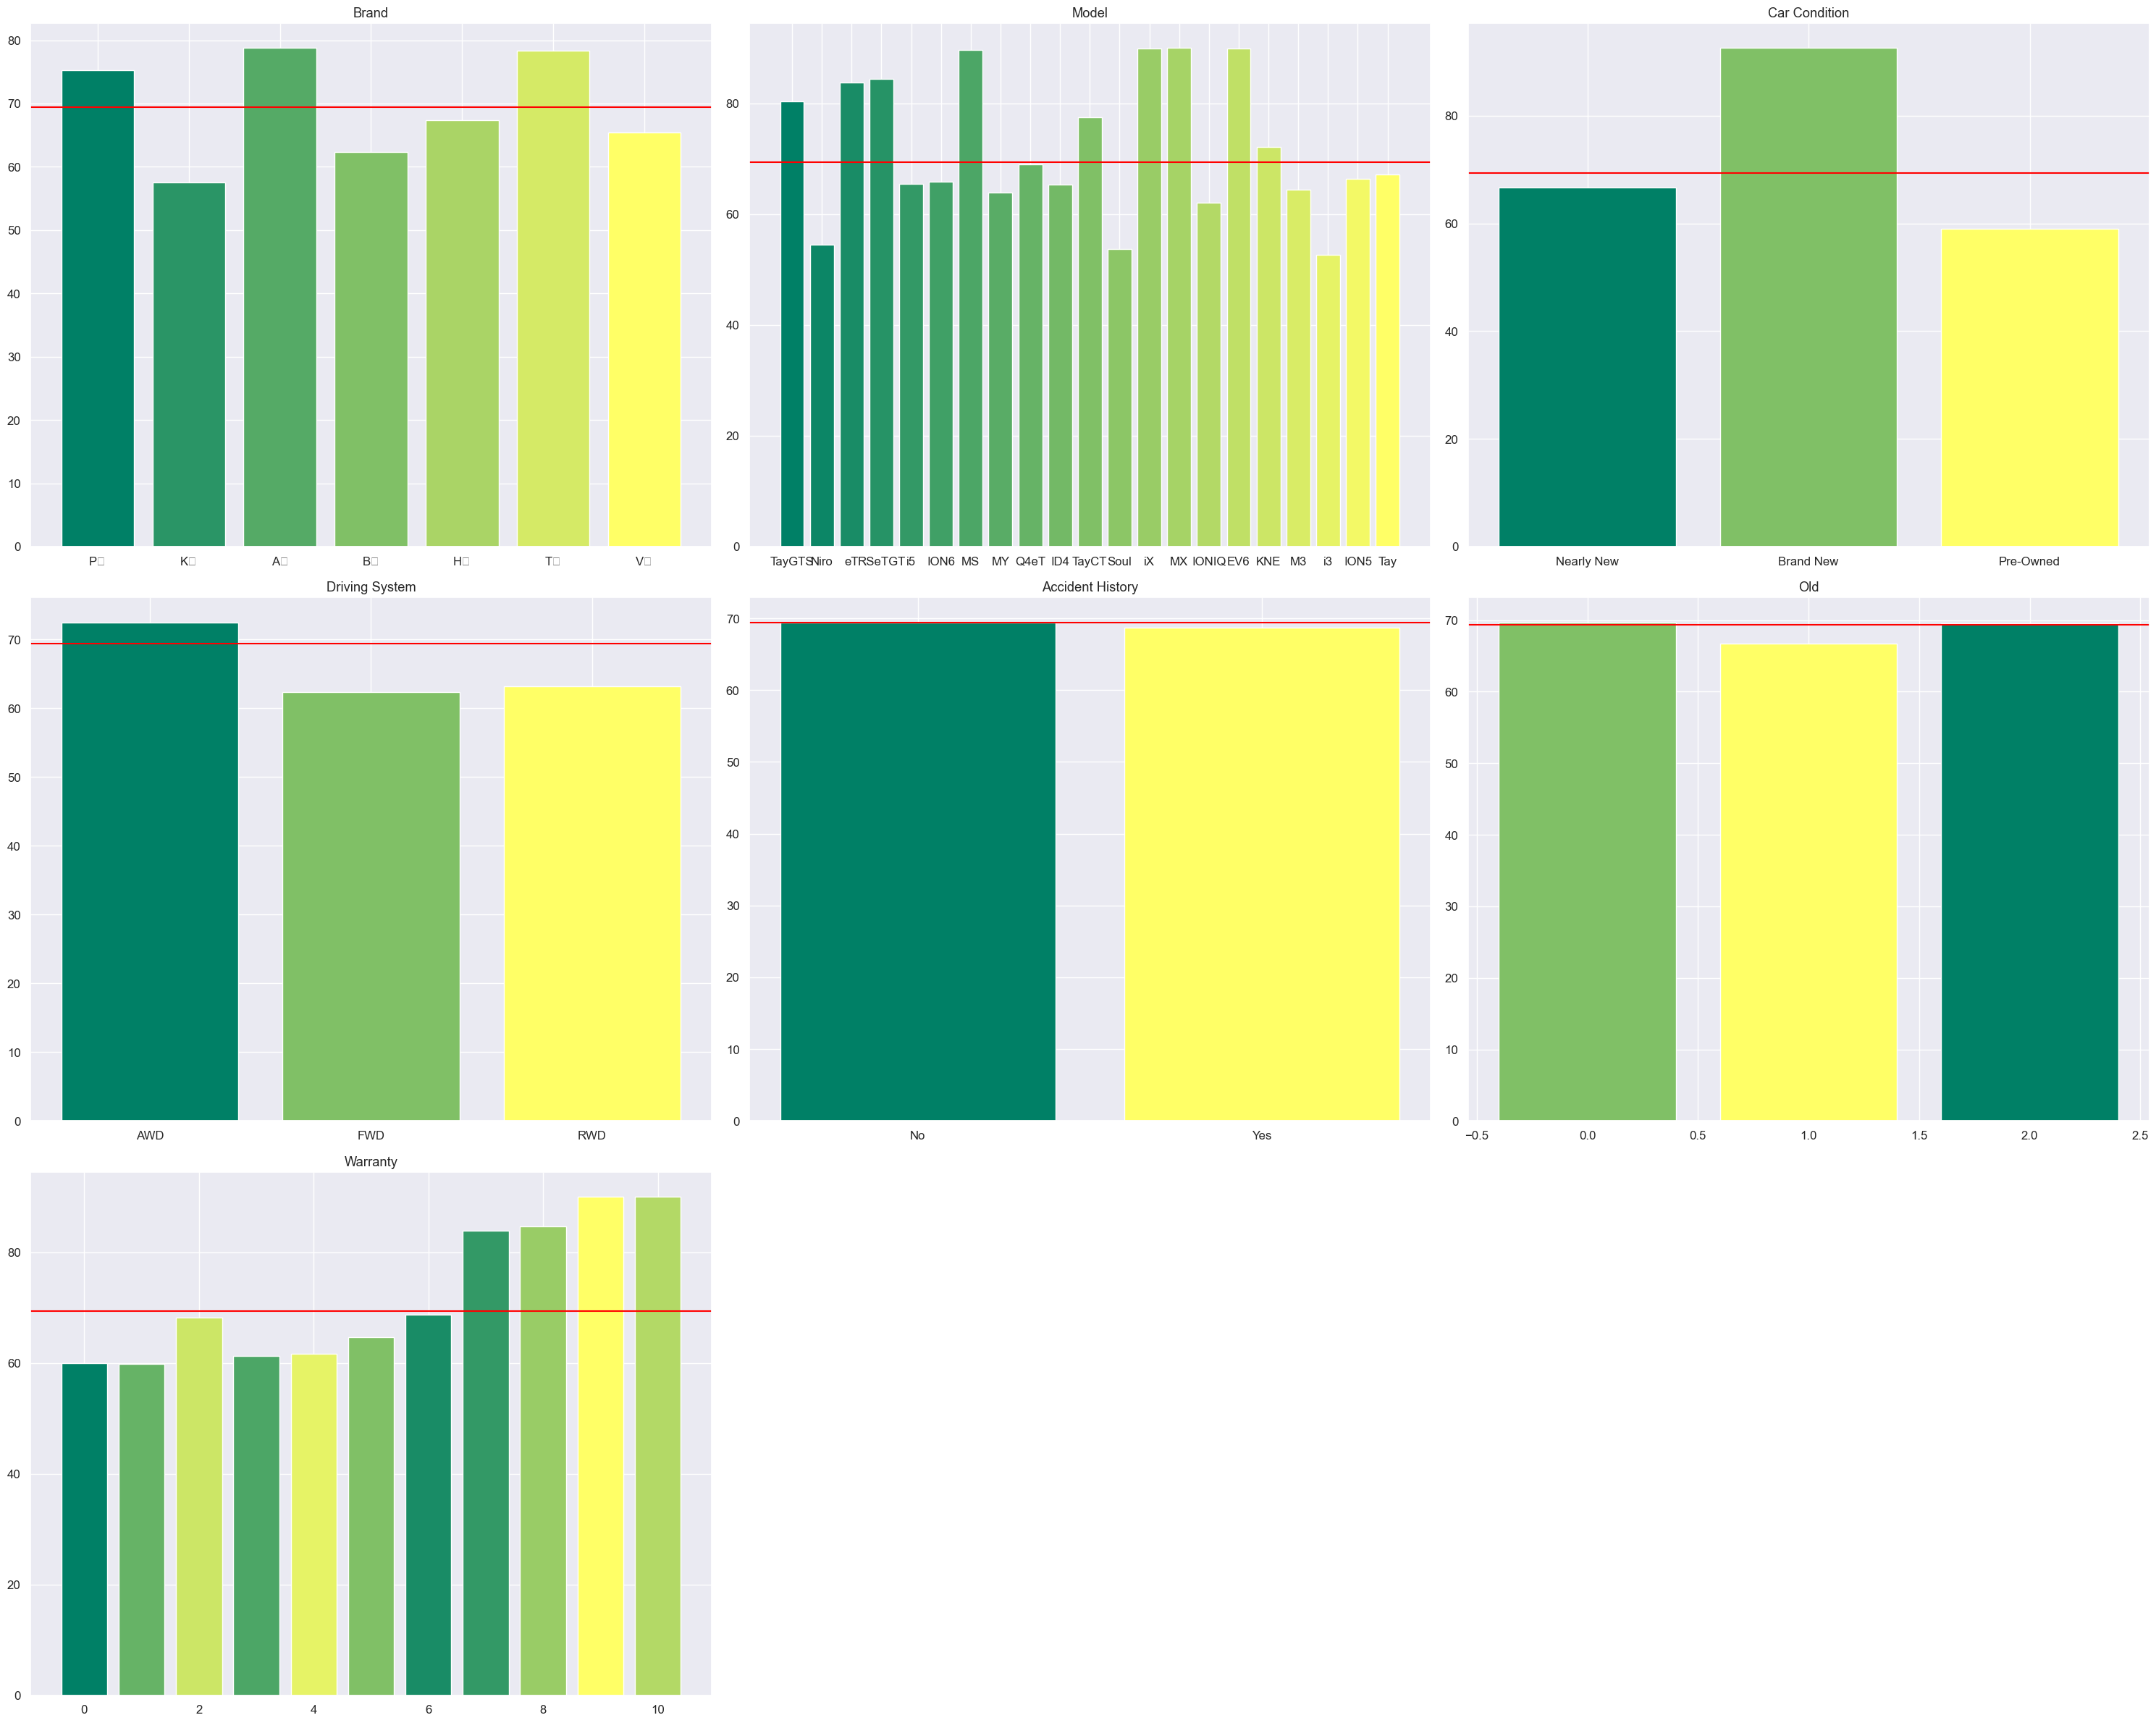

In [158]:
# Define the column keys
column_keys = ['Brand', 'Model', 'Car Condition', 'Driving System', 'Accident History', 'Old', 'Warranty']

# Create subplots with 3 visualizations in one row
fig, axes = plt.subplots(nrows=(len(column_keys) + 2) // 3, ncols=3, figsize=(30, 8 * ((len(column_keys) + 2) // 3)))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each column key and create a bar plot in a subplot
for idx, column_key in enumerate(column_keys):
    ax = axes[idx]
    unique_keys = train[column_key].unique().tolist()
    means = [train[train[column_key] == key]['Battery Capacity'].mean() for key in unique_keys]
    
    bars = ax.bar(unique_keys, means, color=plt.cm.summer(np.linspace(0, 1, len(unique_keys))))
    ax.axhline(y=train['Battery Capacity'].mean(), color='red')
    
    ax.set_title(column_key)

# Remove any unused subplots
for idx in range(len(column_keys), len(axes)):
    fig.delaxes(axes[idx])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [159]:
# Check the mean of warranty period where car condintion is brand new
print(train[train['Car Condition']=='Brand New']['Warranty'].mean())
print(train[train['Car Condition']!='Brand New']['Warranty'].mean())

7.312130177514793
3.03060480932718


In [160]:
# To deal with Battery Capacity
upper7 = train[train['Warranty']>=7]['Battery Capacity'].mean()
lower7 = train[train['Warranty']<7]['Battery Capacity'].mean()

train.fillna(-1, inplace=True)
test.fillna(-1, inplace=True)
def fill_battery(row):
    if row['Battery Capacity'] == -1:
        if row['Warranty'] >= 7:
            return upper7
        else:
            return lower7
    return row['Battery Capacity']

train['Battery Capacity'] = train.apply(fill_battery, axis=1)
test['Battery Capacity'] = test.apply(fill_battery, axis=1)

### EDA

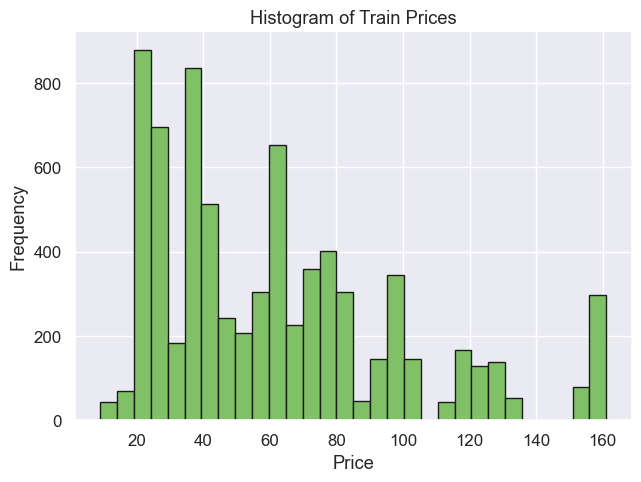

In [287]:
# Plot histogram for the 'Price' column with summer colormap
plt.hist(train['Price'], bins=30, edgecolor='k', color=plt.cm.summer(0.5))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Histogram of Train Prices')
plt.show()

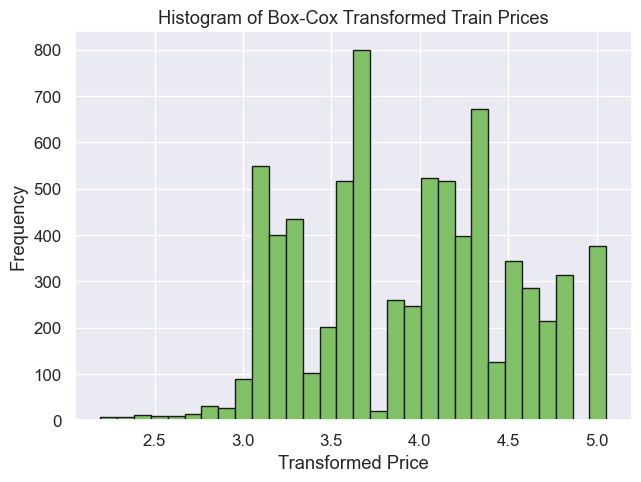

In [288]:
# Assuming the train data is available in a DataFrame named 'train'
# Perform Box-Cox transformation on the 'Price' column
train['Price_BoxCox'], _ = stats.boxcox(train['Price'])

# Plot histogram for the Box-Cox transformed 'Price' column with summer colormap
plt.hist(train['Price_BoxCox'], bins=30, edgecolor='k', color=plt.cm.summer(0.5))
plt.xlabel('Transformed Price')
plt.ylabel('Frequency')
plt.title('Histogram of Box-Cox Transformed Train Prices')
plt.show()

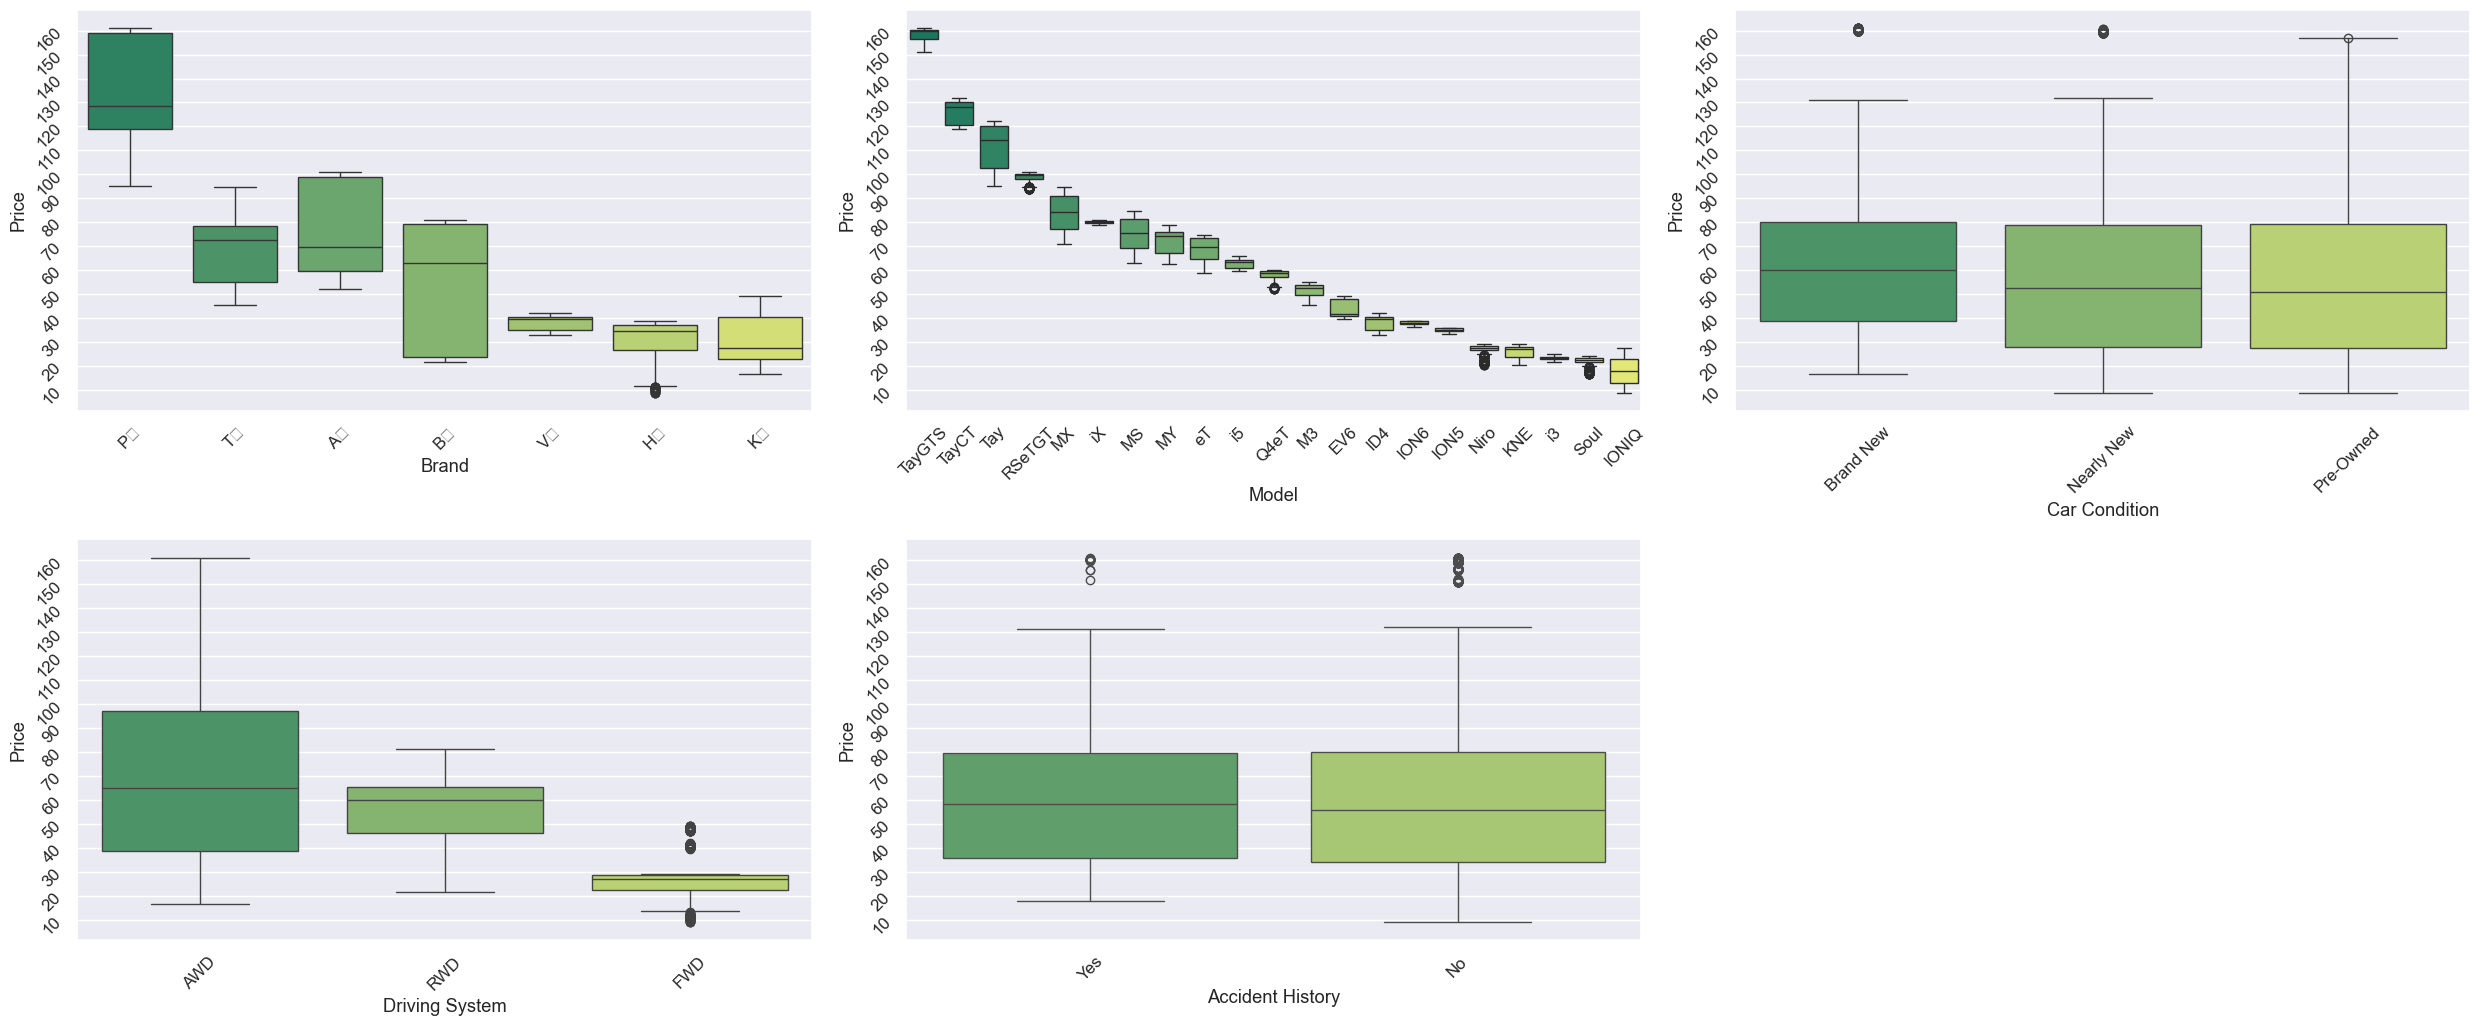

In [ ]:
# For Categorical Variables
def srt_box(y, df):
    '''A function for displaying categorical variables.'''
    
    cat_features = df.select_dtypes(include=['object']).columns
    num_plots = len(cat_features)
    rows = (num_plots // 3) + (num_plots % 3 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, 5 * rows))
    axes = axes.flatten()

    for i, (feature, ax) in enumerate(zip(cat_features, axes)):
        sortd = df.groupby([feature])[y].median().sort_values(ascending=False)
        sns.boxplot(x=feature,
                    y=y,
                    data=df,
                    palette='summer',
                    order=sortd.index,
                    ax=ax)
        ax.tick_params(labelrotation=45)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=18))

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

srt_box('Price', train.drop(columns=['ID'], errors='ignore'))

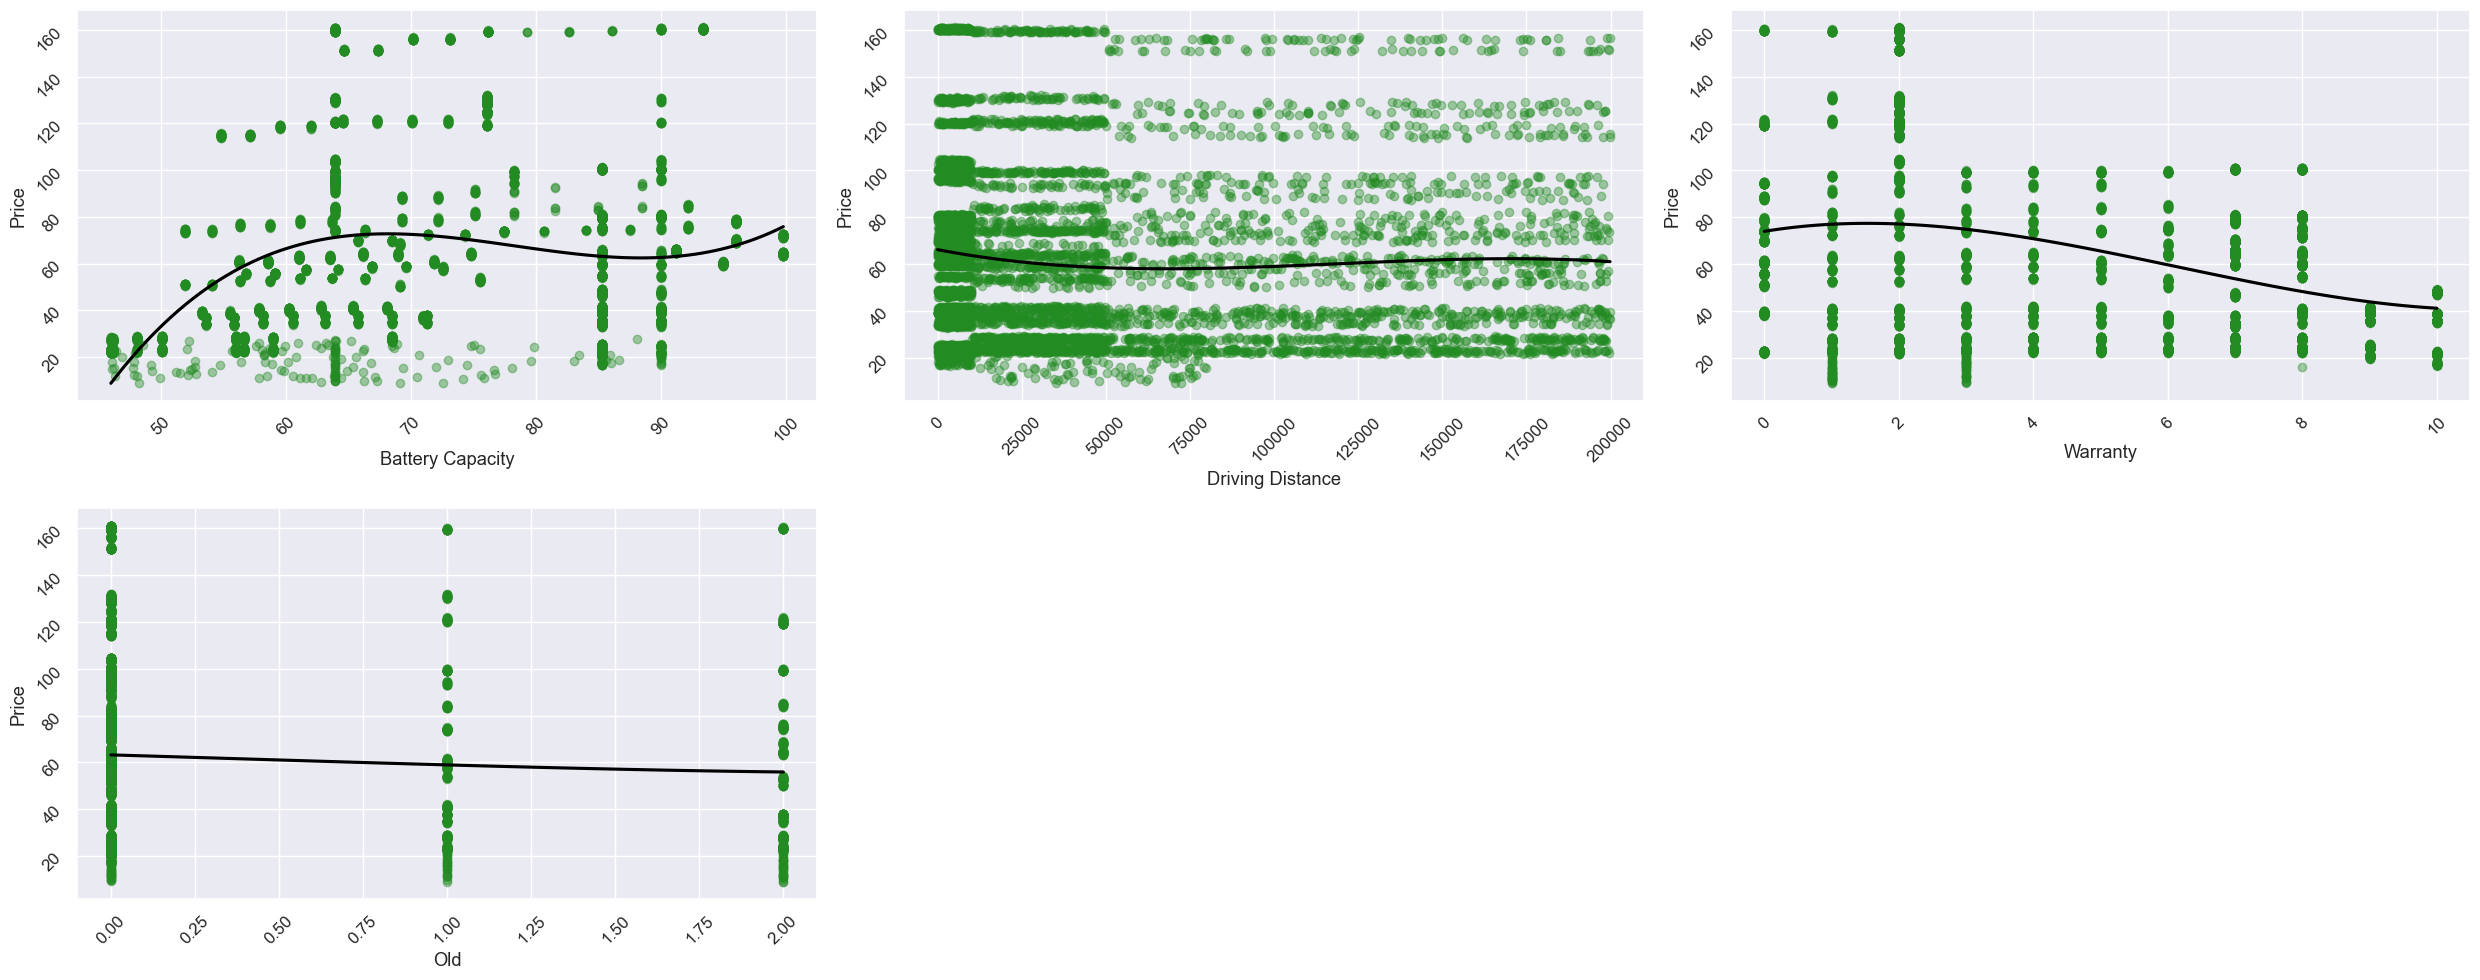

In [ ]:
# For numerical varaibles
def srt_reg(y, df):
    num_features = df.select_dtypes(include=['number']).columns.drop(y)
    num_plots = len(num_features)
    rows = (num_plots // 2) + (num_plots % 2 > 0)
    
    fig, axes = plt.subplots(rows, 3, figsize=(25, 5 * rows))
    axes = axes.flatten()

    for i, (feature, ax) in enumerate(zip(num_features, axes)):
        sns.regplot(x=feature,
                    y=y,
                    data=df,
                    ax=ax,
                    order=3,
                    ci=None,
                    color='forestgreen',
                    line_kws={'color': 'black'},
                    scatter_kws={'alpha': 0.4})
        ax.tick_params(labelrotation=45)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=10))

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()

# Example usage:
srt_reg('Price', train)

### Modeling

In [128]:
# Drop ID column since it is unnecessary for prediction
train_df = train.drop(columns=['ID'])
test_df = test.drop(columns=['ID'])

In [129]:
train_df

,Brand,Model,Car Condition,Battery Capacity,Driving System,Driving Distance,Warranty,Accident History,Old,Price
0,P사,TayGTS,Nearly New,86.077000,AWD,13642,0,No,2,159.66
1,K사,Niro,Nearly New,56.000000,FWD,10199,6,No,0,28.01
2,A사,eT,Brand New,91.200000,AWD,2361,7,No,0,66.27
3,A사,RSeTGT,Nearly New,63.932581,AWD,21683,3,No,0,99.16
4,B사,i5,Pre-Owned,61.018000,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...
7492,H사,ION5,Brand New,85.282460,AWD,3773,10,No,0,35.95
7493,B사,i3,Pre-Owned,46.000000,RWD,135411,2,No,0,23.40
7494,P사,TayCT,Brand New,63.932581,AWD,1363,2,No,0,120.00
7495,B사,i3,Nearly New,56.000000,RWD,39445,6,No,2,24.00


In [130]:
train_df[train_df['Model']=='TayGTS']

,Brand,Model,Car Condition,Battery Capacity,Driving System,Driving Distance,Warranty,Accident History,Old,Price
0,P사,TayGTS,Nearly New,86.077000,AWD,13642,0,No,2,159.66
31,P사,TayGTS,Pre-Owned,64.683000,AWD,97476,2,No,0,151.00
56,P사,TayGTS,Brand New,63.932581,AWD,9161,2,No,0,160.73
106,P사,TayGTS,Brand New,63.932581,AWD,4803,2,No,0,160.16
115,P사,TayGTS,Nearly New,76.156000,AWD,11401,2,No,0,159.71
...,...,...,...,...,...,...,...,...,...,...
7357,P사,TayGTS,Brand New,93.400000,AWD,5501,2,No,0,160.16
7385,P사,TayGTS,Nearly New,63.932581,AWD,25742,2,No,0,159.48
7388,P사,TayGTS,Brand New,93.400000,AWD,9026,2,No,0,161.01
7448,P사,TayGTS,Pre-Owned,70.185000,AWD,184495,2,No,0,156.47


In [315]:
submission = test.copy()

In [316]:
submission['가격(백만원)']=inverse_boxcox_transform(xgb_test_pred, lambda_value)

In [317]:
submission1=submission[['ID','가격(백만원)']]
# Saving submission file with UTF-8 encoding
submission1.to_csv('mysubmission1.csv', index=False, encoding='utf-8-sig')

print('Save submission', datetime.now())

# Displaying the first few rows
print(submission1.head())

Save submission 2025-01-05 00:30:03.668540
         ID     가격(백만원)
0  TEST_000  130.509781
1  TEST_001   80.287636
2  TEST_002   64.763603
3  TEST_003   34.776772
4  TEST_004   48.013840


In [318]:
submission[submission['Model']=='TayGTS'].describe()

,Battery Capacity,Driving Distance,Warranty,Old,가격(백만원)
count,42.000000,42.000000,42.000000,42.000000,42.000000
mean,73.782257,63771.904762,1.928571,0.071429,157.287323
std,10.831136,63893.716604,0.341650,0.341650,3.317612
min,63.932581,2620.000000,0.000000,0.000000,151.092438
25%,64.683000,8789.750000,2.000000,0.000000,155.889473
50%,70.185000,30378.500000,2.000000,0.000000,159.159828
75%,76.156000,124491.250000,2.000000,0.000000,159.922638
max,93.400000,192434.000000,2.000000,2.000000,161.283142


In [319]:
train_df[train_df['Model']=='TayGTS'].describe()

,Battery Capacity,Driving Distance,Warranty,Old,Price
count,375.000000,375.000000,375.000000,375.000000,375.000000
mean,75.343492,43993.781333,1.816000,0.184000,158.298747
std,11.971632,55190.606067,0.528098,0.528098,3.019670
min,63.932581,4.000000,0.000000,0.000000,151.000000
25%,63.932581,5699.000000,2.000000,0.000000,156.375000
50%,70.185000,16159.000000,2.000000,0.000000,159.890000
75%,90.000000,62124.000000,2.000000,0.000000,160.110000
max,93.400000,199760.000000,2.000000,2.000000,161.090000


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming train_df and test_df are already loaded as DataFrames

# Drop the 'Id' column if it exists in train_df and test_df
train_df = train_df.drop(columns=['Id'], errors='ignore')
test_df = test_df.drop(columns=['Id'], errors='ignore')

# Separate features and target variable from train_df
X = train_df.drop(columns=['Price'])
y = train_df['Price']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

# Align the columns of test_df with X (train_df)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Assign sample weights based on the 'Model' column
model_columns = [col for col in X.columns if col.startswith('Model_')]
sample_weights = np.ones(len(X))
for col in model_columns:
    sample_weights += X[col] * 6  # Adjust the weight as needed

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val, sample_weights_train, sample_weights_val = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [20,30],
    'min_samples_leaf': [4, 8]
}

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the training data with sample weights
grid_search.fit(X_train, y_train, sample_weight=sample_weights_train)

# Get the best parameters from GridSearchCV
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the RandomForestRegressor model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Predict on the validation set
y_pred = best_rf_model.predict(X_val)

# Calculate and print the mean squared error
mse = mean_squared_error(y_val, y_pred)
print(f"Mean Squared Error: {mse}")

# Predict on the test set
test_predictions = best_rf_model.predict(test_df)

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 300}
Mean Squared Error: 1.8930240704897106
Random Forest model with cross-validation and adjusted sample weights has been trained and predictions have been made on the test set.


In [ ]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.linear_model import TweedieRegressor
import xgboost as xgb
import numpy as np

# Some parameters for ridge, lasso and elasticnet.
alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [
    int(5e-05), 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# Assuming train_df and test_df are already loaded as DataFrames

# Drop the 'Id' column if it exists in train_df and test_df
train_df = train_df.drop(columns=['Id'], errors='ignore')
test_df = test_df.drop(columns=['Id'], errors='ignore')

# Separate features and target variable from train_df
X = train_df.drop(columns=['Price'])
y = train_df['Price']

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

# Align the columns of test_df with X (train_df)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Assign sample weights based on the 'Model' column for RandomForestRegressor
model_columns = [col for col in X.columns if col.startswith('Model_')]
sample_weights = np.ones(len(X))
for col in model_columns:
    sample_weights += X[col] * 7  # Adjust the weight as needed

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val, sample_weights_train, sample_weights_val = train_test_split(
    X, y, sample_weights, test_size=0.3, random_state=42)

# Define the parameter grid for GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [4, 8]
}

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation for RandomForestRegressor
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the training data with sample weights for RandomForestRegressor
grid_search.fit(X_train, y_train, sample_weight=sample_weights_train)

# Get the best parameters from GridSearchCV for RandomForestRegressor
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the RandomForestRegressor model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train, sample_weight=sample_weights_train)

# Predict on the validation set for RandomForestRegressor
y_pred = best_rf_model.predict(X_val)

# Predict on the test set for RandomForestRegressor
test_predictions_rf = best_rf_model.predict(test_df)

# Define other models to be tested
ridge = Ridge()
lasso = Lasso()
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=int(1e7),
                 alphas=e_alphas,
                 cv=kf,
                 l1_ratio=e_l1ratio))
gbr = GradientBoostingRegressor()
lightgbm = lgb.LGBMRegressor()
svr = SVR()
tweedie = make_pipeline(RobustScaler(),TweedieRegressor(alpha=0.005))
linear_reg = LinearRegression()
xgboost = xgb.XGBRegressor()

# List of estimators and their labels
estimators = [linear_reg, ridge, lasso, elasticnet, best_rf_model, gbr, lightgbm, svr, tweedie, xgboost]
labels = [
    'LinearRegression', 'Ridge', 'Lasso', 'Elasticnet', 'RandomForestRegressor',
    'GradientBoostingRegressor', 'LGBMRegressor', 'SVR', 'TweedieRegressor', 'XGBoost'
]

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def model_check(X, y, estimators, labels, cv):
    
    ''' A function for testing multiple estimators.'''
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results['train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results['test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'], ascending=True, inplace=True)

    return model_table

# Executing cross-validation.
raw_models = model_check(X, y, estimators, labels, kf)
display(raw_models.style.background_gradient(cmap='summer_r'))

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 300}
Mean Squared Error: 1.7966137875509665


,Model Name,Train RMSE,Test RMSE,Test Std,Time
6,LGBMRegressor,1.345322,1.809199,0.344156,0.621464
4,RandomForestRegressor,1.254509,1.894567,0.526747,4.389864
9,XGBoost,0.650407,2.236340,0.510092,0.166429
5,GradientBoostingRegressor,8.704936,8.940745,0.820290,0.715622
3,Elasticnet,13.592732,13.739122,0.891746,1.102638
0,LinearRegression,13.592413,13.739766,0.891876,0.010470
1,Ridge,13.600215,13.746516,0.898382,0.007867
8,TweedieRegressor,19.193143,19.368755,1.298965,0.043791
2,Lasso,212.935152,213.981799,10.029540,0.017052
7,SVR,1403.279206,1406.080762,101.466571,2.924832


In [297]:
# Predict on the validation set for RandomForestRegressor
rf_val_pred = best_rf_model.predict(X_val)
rf_test_pred = best_rf_model.predict(test_df)

# Train the LightGBM model
lgb_model = lgb.LGBMRegressor(random_state=42)
lgb_model.fit(X_train, y_train)
lgb_val_pred = lgb_model.predict(X_val)
lgb_test_pred = lgb_model.predict(test_df)

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_val_pred = xgb_model.predict(X_val)
xgb_test_pred = xgb_model.predict(test_df)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 428
[LightGBM] [Info] Number of data points in the train set: 5247, number of used features: 35
[LightGBM] [Info] Start training from score 3.945681


In [300]:
# Create a stacked model with weights 0.4 for LightGBM and RandomForest, and 0.2 for XGBoost
stacked_val_pred = 0.5 * lgb_val_pred + 0.5 * rf_val_pred 
stacked_test_pred = 0.5 * lgb_test_pred + 0.5 * rf_test_pred

# Calculate and print the mean squared error for the stacked model on validation set
stacked_mse = mean_squared_error(y_val, stacked_val_pred)
print(f"Stacked Model Mean Squared Error: {stacked_mse}")

print("Stacked model has been created and predictions have been made on the test set.")

Stacked Model Mean Squared Error: 0.0019685029232481177
Stacked model has been created and predictions have been made on the test set.


In [308]:
inverse_boxcox_transform(lgb_test_pred, lambda_value)

array([130.50897381,  80.03736276,  64.37107178,  35.10254239,
        48.29947118,  99.73735985,  22.07654248,  39.99289606,
        81.00516905,  24.14194121,  64.42495845,  62.91580612,
        40.29370415,  99.9066757 ,  90.21608917,  22.51740521,
       126.63882363,  52.55832382,  60.25166657,  34.50329463,
        37.97762924, 159.99067985,  47.20453103,  55.84322115,
        23.1035872 ,  47.98406394,  79.1726291 ,  79.87096221,
        27.91090454, 126.63882363,  64.41789872,  41.15648662,
       114.44742799,  88.20314076,  35.69076289,  80.03736276,
        22.51779219,  39.7966519 ,  24.75587149, 122.63769793,
       125.61516006,  18.48938353, 119.51699414,  61.47701999,
        23.15474321,  99.95791082,  22.01806944,  74.08362082,
        63.50314491,  77.26724099,  35.67402198,  14.78523882,
        38.72977649, 126.63882363,  23.75221377,  27.85632964,
       155.78429816,  41.11035169, 158.64293382,  40.29370415,
        55.82352237, 125.25150322,  40.72802771, 120.80

In [296]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNetCV, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import lightgbm as lgb
from sklearn.linear_model import TweedieRegressor
import xgboost as xgb
from scipy import stats

# Box-Cox transformation requires strictly positive values
def boxcox_transform(y):
    # Shift target variable to make it strictly positive if needed
    min_y = y.min()
    if min_y <= 0:
        y += abs(min_y) + 1
    y_transformed, lambda_value = stats.boxcox(y)
    return y_transformed, lambda_value

def inverse_boxcox_transform(y_transformed, lambda_value):
    """ Revert the Box-Cox transformation """
    if lambda_value == 0:
        return np.exp(y_transformed)  # Inverse of log transformation
    else:
        return np.power((y_transformed * lambda_value) + 1, 1 / lambda_value)

# Assuming train_df and test_df are already loaded as DataFrames
train_df = train_df.drop(columns=['Id'], errors='ignore')
test_df = test_df.drop(columns=['Id'], errors='ignore')

# Separate features and target variable from train_df
X = train_df.drop(columns=['Price'])
y = train_df['Price']

# Apply one-hot encoding to categorical variables
X = pd.get_dummies(X, drop_first=True)
test_df = pd.get_dummies(test_df, drop_first=True)

# Align the columns of test_df with X (train_df)
test_df = test_df.reindex(columns=X.columns, fill_value=0)

# Apply Box-Cox transformation to the target variable
y_transformed, lambda_value = boxcox_transform(y)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y_transformed, test_size=0.3, random_state=42)

# Define the parameter grid for GridSearchCV for RandomForestRegressor
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [20, 30],
    'min_samples_leaf': [4, 8]
}

# Initialize the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV with cross-validation for RandomForestRegressor
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=10, n_jobs=-1, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the training data for RandomForestRegressor
grid_search.fit(X_train, y_train)

# Get the best parameters from GridSearchCV for RandomForestRegressor
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the RandomForestRegressor model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Predict on the validation set for RandomForestRegressor
y_pred_transformed = best_rf_model.predict(X_val)

# Inverse Box-Cox transformation for RMSE calculation on the original scale
y_val_reverted = inverse_boxcox_transform(y_val, lambda_value)
y_pred_reverted = inverse_boxcox_transform(y_pred_transformed, lambda_value)

# Calculate RMSE on the original scale (inverse-reverted)
mse = mean_squared_error(y_val_reverted, y_pred_reverted)
rmse = np.sqrt(mse)
print(f"Random Forest Reverted RMSE: {rmse}")

# Predict on the test set for RandomForestRegressor
test_predictions_rf = best_rf_model.predict(test_df)

# Inverse Box-Cox transformation on the test predictions
test_predictions_reverted_rf = inverse_boxcox_transform(test_predictions_rf, lambda_value)

# Define other models to be tested
ridge = Ridge()
lasso = Lasso()
elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=int(1e7),
                 alphas=e_alphas,
                 cv=10,
                 l1_ratio=e_l1ratio))
gbr = GradientBoostingRegressor()
lightgbm = lgb.LGBMRegressor()
svr = SVR()
tweedie = make_pipeline(RobustScaler(),TweedieRegressor(alpha=0.005))
linear_reg = LinearRegression()
xgboost = xgb.XGBRegressor()

# List of estimators and their labels
estimators = [linear_reg, ridge, lasso, elasticnet, best_rf_model, gbr, lightgbm, svr, tweedie, xgboost]
labels = [
    'LinearRegression', 'Ridge', 'Lasso', 'Elasticnet', 'RandomForestRegressor',
    'GradientBoostingRegressor', 'LGBMRegressor', 'SVR', 'TweedieRegressor', 'XGBoost'
]

# Define cross-validation strategy
kf = KFold(n_splits=10, shuffle=True, random_state=42)

def model_check(X, y_transformed, estimators, labels, cv, lambda_value=None):
    ''' A function for testing multiple estimators with inverse Box-Cox RMSE calculation. '''
    
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        # Perform cross-validation and get predictions on transformed scale
        cv_results_train = []
        cv_results_test = []
        for train_idx, test_idx in cv.split(X):
            est.fit(X.iloc[train_idx], y_transformed[train_idx])
            y_train_pred_transformed = est.predict(X.iloc[train_idx])
            y_test_pred_transformed = est.predict(X.iloc[test_idx])
            cv_results_train.append(mean_squared_error(inverse_boxcox_transform(y_transformed[train_idx], lambda_value), 
                                                       inverse_boxcox_transform(y_train_pred_transformed, lambda_value)))
            cv_results_test.append(mean_squared_error(inverse_boxcox_transform(y_transformed[test_idx], lambda_value), 
                                                      inverse_boxcox_transform(y_test_pred_transformed, lambda_value)))

        # Calculate RMSE on original scale (inverse-reverted)
        train_rmse_reverted = np.sqrt(np.mean(cv_results_train))
        test_rmse_reverted = np.sqrt(np.mean(cv_results_test))

        # Add the results to the model table
        model_table.loc[row_index, 'Train RMSE'] = train_rmse_reverted
        model_table.loc[row_index, 'Test RMSE'] = test_rmse_reverted
        model_table.loc[row_index, 'Test Std'] = np.std(cv_results_test)
        model_table.loc[row_index, 'Time'] = np.mean(cv_results_test)

        row_index += 1

    model_table.sort_values(by=['Test RMSE'], ascending=True, inplace=True)

    return model_table

# Executing cross-validation with Box-Cox inversion for RMSE calculation
raw_models = model_check(X, y_transformed, estimators, labels, kf, lambda_value)
display(raw_models.style.background_gradient(cmap='summer_r'))

Best parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 300}
Random Forest Reverted RMSE: 1.3381457947944317
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 6747, number of used features: 35
[LightGBM] [Info] Start training from score 3.945858
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 432
[LightGBM] [Info] Numbe

,Model Name,Train RMSE,Test RMSE,Test Std,Time
6,LGBMRegressor,1.211941,1.384901,0.336118,1.917951
4,RandomForestRegressor,1.122571,1.385737,0.549339,1.920266
9,XGBoost,0.880621,1.503085,0.405111,2.259263
5,GradientBoostingRegressor,3.339763,3.388088,1.203763,11.479138
3,Elasticnet,3.773596,3.795237,0.757448,14.403820
1,Ridge,3.800469,3.822527,0.794755,14.611709
0,LinearRegression,3.814936,3.837415,0.810617,14.725754
8,TweedieRegressor,4.584681,4.603325,1.546532,21.190598
2,Lasso,37.378656,37.382289,103.065128,1397.435563
7,SVR,37.882748,37.921961,101.876203,1438.075117
